In [ ]:
import os

from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive')

### Set up data folder

In [ ]:
drive_path = os.getcwd()
os.getcwd()

'/content/drive/MyDrive'

In [ ]:
try:
  os.makedirs(os.path.join(drive_path,'PROJET_PERSO/Gender_Recognition'))
except:
  pass

In [ ]:
os.chdir(os.path.join(drive_path,'PROJET_PERSO/Gender_Recognition'))

In [ ]:
project_path = os.getcwd()

### Scrapping on TMDB API

In [ ]:
import requests

from skimage import io
import cv2

from tqdm import tqdm

import glob

In [ ]:
imgbase_path = "https://www.themoviedb.org/t/p/original/"

In [ ]:
api_key = "YOUR API KEY accessible on https://developers.themoviedb.org/3/getting-started/introduction"

In [ ]:
def dataset_creation(key="", img_num=50):

  page = 1
  imgbase_path = "https://www.themoviedb.org/t/p/w400/"
  test = requests.get(f"https://api.themoviedb.org/3/person/1?api_key={key}&language=en-US").status_code

  face_cascade = cv2.CascadeClassifier('/usr/local/lib/python3.7/dist-packages/cv2/data/haarcascade_frontalface_alt2.xml')

  if test != 200 :
    print('Invalid API key !')
    return 0
  
  if img_num < 1:
    print("The number of image should be at least greater than 1 !")
    return 0


  project_path = os.getcwd()
  woman_path = os.path.join(project_path, 'Female')
  man_path = os.path.join(project_path, 'Male')

  try:
    os.makedirs(woman_path)
    os.makedirs(man_path)
  except:
    pass

  with tqdm(total=100) as pbar:
    while (len(os.listdir(woman_path))<img_num or len(os.listdir(man_path))<img_num):

      elms = requests.get(f"https://api.themoviedb.org/3/person/popular?api_key={key}&language=en-US&page={page}").json()['results']

      for elm in elms:

        req = requests.get(f"https://api.themoviedb.org/3/person/{elm['id']}?api_key={key}&language=en-US")
        data = req.json()

        if req.status_code == 200 : 
          if data['profile_path']:

            img = io.imread(imgbase_path+data['profile_path'])
            
            try:
              img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
              faces = face_cascade.detectMultiScale(img_gray, 1.1, 4)
            except: #Means the image is already in grayscale
              faces = face_cascade.detectMultiScale(img, 1.1, 4)

            if len(faces)==1 :
              x, y, w, h = faces[0]
              crop_face = img[y:y + h, x:x + w]

              if int(data['gender']) == 1 and len(os.listdir(woman_path))<img_num:
                io.imsave(os.path.join(woman_path, f'{elm["id"]}.jpg'), crop_face)
                pbar.update((1/(2*img_num)) * 100)

              elif int(data['gender']) == 2 and len(os.listdir(man_path))<img_num:
                io.imsave(os.path.join(man_path, f'{elm["id"]}.jpg'), crop_face)
                pbar.update((1/(2*img_num)) * 100)

      page +=1
      if (len(os.listdir(woman_path))>=img_num and len(os.listdir(man_path))>=img_num): break

In [ ]:
dataset_creation(api_key, 1000)

  0%|          | 0/100 [00:00<?, ?it/s]


### SCRAPPING GOOGLE IMAGES

In [ ]:
"""
!apt update
!apt install chromium-chromedriver
!pip install selenium
"""
#Used to add different data to our dataset (as there was not much black people)

from selenium import webdriver
import time
import requests
from PIL import Image
from skimage import io
import hashlib
import cv2

def fetch_image_urls(query:str, max_links_to_fetch:int, wd:webdriver, sleep_between_interactions:int=1):
    def scroll_to_end(wd):
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_between_interactions)        
    
    # build the google query
    search_url = "https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"

    # load the page
    wd.get(search_url.format(q=query))

    image_urls = set()
    image_count = 0
    results_start = 0
    error_clicks = 0
    while (image_count < max_links_to_fetch) & (error_clicks < 30): # error clicks to stop when there are no more results to show by Google Images. You can tune the number
        scroll_to_end(wd)

        print('Starting search for Images')

        # get all image thumbnail results
        thumbnail_results = wd.find_elements_by_css_selector("img.Q4LuWd")
        number_results = len(thumbnail_results)
        
        print(f"Found: {number_results} search results. Extracting links from {results_start}:{number_results}")
        for img in thumbnail_results[results_start:max_links_to_fetch]:
            # try to click every thumbnail such that we can get the real image behind it
            print("Total Errors till now:", error_clicks)
            try:
                print('Trying to Click the Image')
                img.click()
                time.sleep(sleep_between_interactions)
                print('Image Click Successful!')
            except Exception:
                error_clicks = error_clicks + 1
                print('ERROR: Unable to Click the Image')
                if(results_start < number_results):
                	continue
                else:
                	break
                	
            results_start = results_start + 1

            # extract image urls    
            print('Extracting of Image URLs')
            actual_images = wd.find_elements_by_css_selector('img.n3VNCb')
            for actual_image in actual_images:
                if actual_image.get_attribute('src') and 'http' in actual_image.get_attribute('src'):
                    image_urls.add(actual_image.get_attribute('src'))

            image_count = len(image_urls)

            print('Current Total Image Count:', image_count)

            if len(image_urls) >= max_links_to_fetch:
                print(f"Found: {len(image_urls)} image links, done!")
                break
            else:
                load_more_button = wd.find_element_by_css_selector(".mye4qd")
                if load_more_button:
                    wd.execute_script("document.querySelector('.mye4qd').click();")
            	        
        results_start = len(thumbnail_results)

    return image_urls

def persist_image(folder_path:str,file_name:str,url:str):
    face_cascade = cv2.CascadeClassifier('/usr/local/lib/python3.7/dist-packages/cv2/data/haarcascade_frontalface_alt2.xml')
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")

    try:
        image_file = io.imread(url)
        #image = Image.open(image_file).convert('RGB')
        #folder_path = os.path.join(folder_path,file_name)
        img_gray = cv2.cvtColor(image_file, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(img_gray, 1.1, 4)
        if len(faces)==1 :
          x, y, w, h = faces[0]
          crop_face = image_file[y:y + h, x:x + w]
          if os.path.exists(folder_path):
              file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
          else:
              os.mkdir(folder_path)
              file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
          io.imsave(file_path, crop_face)
          """
          with open(file_path, 'wb') as f:
              image.save(f, "JPEG", quality=85)"""
          print(f"SUCCESS - saved {url} - as {file_path}")
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")



options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

wd = webdriver.Chrome(options=options)
queries = {"Female" :"Black Woman", "Male":"Black Man"}  #change your set of queries here
for folder, query in queries.items():
    wd.get('https://google.com')
    search_box = wd.find_element_by_css_selector('input.gLFyf')
    search_box.send_keys(query)
    links = fetch_image_urls(query, 100, wd) 
    images_path = project_path+"/"+folder
    for i in links:
        persist_image(images_path,query,i)
wd.quit()

In [ ]:
len(os.listdir('Male'))

1073

In [ ]:
len(os.listdir('Female'))

1067

### Preprocessing

In [ ]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras import models as KM
from tensorflow.keras import layers as KL
from tensorflow.keras import backend as K

In [ ]:
#BASE PARAMETERS
IMG_DIMS = (64, 64, 3)
LR = 0.001
EPOCHS = 75
BATCHSIZE = 128

In [ ]:
project_path

'/content/drive/MyDrive/PROJET_PERSO/Gender_Recognition_TEST'

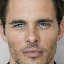

In [ ]:
from google.colab.patches import cv2_imshow

a = cv2.imread(f"{project_path}/Male/{os.listdir('Male')[67]}")
a = cv2.resize(a, IMG_DIMS[:2])
cv2_imshow(a)

In [ ]:
def train_test_creation(dataset_size = 100):

  assert dataset_size >= 1
  
  all_imgs = []
  labels = []
  genders = ('Male','Female')

  print('Creation of the dataset...')
  #Append image and their corresponding label in lists
  for gender in genders:

    for img in glob.glob(f'{gender}/*.jpg')[:dataset_size]:
      try:
        current = cv2.imread(f"{project_path}/{img}")
        current = cv2.resize(current, IMG_DIMS[:2])
        all_imgs.append(img_to_array(current))

        if gender == "Male" : labels.append(0)
        else : labels.append(1)
      except:
        pass
    print(f'All {gender} have been added.')
  print('')

  print('Normalizing features...')
  #Convert image array to float and normalize it
  all_imgs = np.array(all_imgs, dtype="float")
  all_imgs /= 255.0

  print('Dealing with labels...')
  #Resize labels list shape to fit with all_imgs shape
  labels = np.array(labels)
  labels = labels.reshape(-1, 1)
  labels = to_categorical(labels, num_classes=2)

  X_train, X_test, y_train, y_test = train_test_split(all_imgs, labels, train_size=0.75, 
                                                      shuffle=True, random_state=10)

  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = train_test_creation(1100)

Creation of the dataset...
All Male have been added.
All Female have been added.

Normalizing features...
Dealing with labels...


In [ ]:
X_train.shape

(1602, 64, 64, 3)

In [ ]:
print(f"Number of male in the train set : {len([y for y in y_train if (y==np.array([1.,0.])).all()])}")
print(f"Number of female in the train set : {len([y for y in y_train if (y==np.array([0.,1.])).all()])}\n")

print(f"Number of male in the test set : {len([y for y in y_test if (y==np.array([1.,0.])).all()])}")
print(f"Number of female in the test set : {len([y for y in y_test if (y==np.array([0.,1.])).all()])}")

Number of male in the train set : 794
Number of female in the train set : 808

Number of male in the test set : 279
Number of female in the test set : 255


In [ ]:
# USING IMAGEDATAGENERATOR TO GENERATE OTHERS IMAGES FROM ONE IMAGE

datagen = ImageDataGenerator(rotation_range=0.2, height_shift_range=0.05, width_shift_range=0.05, zoom_range=0.2, shear_range=0.2, horizontal_flip=True, fill_mode="nearest")
datagen.fit(X_train)

### Model conception

In [ ]:
def build_model(height, width, channel):
  #Check the position of channels in Keras backend
  if K.image_data_format() == "channels_last":
    channel_axis = -1
    input_shape = (height, width, channel)
  
  else :
    channel_axis = 1 # First axis is batch_size
    input_shape = (channel, height, width)

  model = KM.Sequential()

  model.add(KL.Conv2D(filters=32, kernel_size=5, padding='same', kernel_initializer="he_uniform", input_shape=input_shape))
  model.add(KL.BatchNormalization(axis=channel_axis))
  model.add(KL.Activation("relu"))
  model.add(KL.MaxPool2D(pool_size=2, strides=2, padding="same"))
  model.add(KL.Dropout(0.3))

  model.add(KL.Conv2D(filters=64, kernel_size=5, padding='same', kernel_initializer="he_uniform"))
  model.add(KL.BatchNormalization(axis=channel_axis))
  model.add(KL.Activation("relu"))
  model.add(KL.MaxPool2D(pool_size=2, strides=2, padding="same"))
  model.add(KL.Dropout(0.3))
  
  
  model.add(KL.Flatten())
  model.add(KL.Dense(512, kernel_initializer="he_uniform", kernel_regularizer=l2(0.0001)))
  model.add(KL.BatchNormalization())
  model.add(KL.Activation("relu"))
  model.add(KL.Dropout(0.5))

  model.add(KL.Dense(2))
  model.add(KL.Activation("softmax"))

  return model


In [ ]:
model = build_model(*IMG_DIMS)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        2

In [ ]:
opt = Adam(learning_rate=LR, decay=LR/EPOCHS)
#opt_sgd = SGD(learning_rate=LR, decay=LR/EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics="accuracy")

In [ ]:
#FITTING WITH DATA IMAGE GENERATOR

hist = model.fit(datagen.flow(X_train, y_train, batch_size=BATCHSIZE), validation_data=(X_test, y_test),
          epochs = EPOCHS, steps_per_epoch=(X_train.shape[0]//BATCHSIZE), verbose=1)

Epoch 1/75
12/12 [==============================] - 35s 171ms/step - loss: 1.0630 - accuracy: 0.6746 - val_loss: 3.9244 - val_accuracy: 0.4831
Epoch 2/75
12/12 [==============================] - 2s 133ms/step - loss: 0.5805 - accuracy: 0.8234 - val_loss: 0.7948 - val_accuracy: 0.7285
Epoch 3/75
12/12 [==============================] - 2s 134ms/step - loss: 0.4258 - accuracy: 0.8740 - val_loss: 0.4143 - val_accuracy: 0.8801
Epoch 4/75
12/12 [==============================] - 2s 136ms/step - loss: 0.4218 - accuracy: 0.8894 - val_loss: 0.4565 - val_accuracy: 0.8558
Epoch 5/75
12/12 [==============================] - 2s 139ms/step - loss: 0.4088 - accuracy: 0.8835 - val_loss: 0.4943 - val_accuracy: 0.8371
Epoch 6/75
12/12 [==============================] - 2s 144ms/step - loss: 0.3682 - accuracy: 0.9048 - val_loss: 0.4364 - val_accuracy: 0.8614
Epoch 7/75
12/12 [==============================] - 2s 137ms/step - loss: 0.3313 - accuracy: 0.9208 - val_loss: 0.4168 - val_accuracy: 0.8820
Epoch

### Plot model results

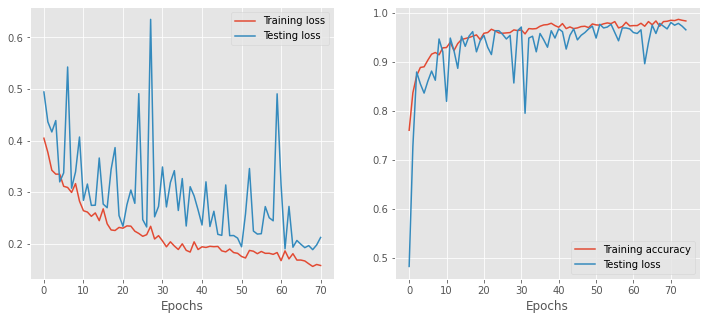

In [ ]:
plt.style.use("ggplot")
fig, ax = plt.subplots(1,2, figsize=(12, 5))

#Starting from the 4th epochs to have a better visualisation of the decreasing loss
ax[0].plot(hist.history["loss"][4:], label="Training loss")
ax[0].plot(hist.history["val_loss"][4:], label="Testing loss")
ax[0].set_xlabel("Epochs") ; ax[0].legend()

ax[1].plot(hist.history["accuracy"], label="Training accuracy")
ax[1].plot(hist.history["val_accuracy"], label="Testing loss")
ax[1].set_xlabel("Epochs") ; ax[1].legend()

plt.show()

In [ ]:
num_model = round(np.mean(model.evaluate(X_test, y_test)[-1]),3)
num_model

17/17 [==============================] - 0s 5ms/step - loss: 0.2122 - accuracy: 0.9663


0.966

In [ ]:
model.save(f'gender_detection_{IMG_DIMS[0]}_{str(num_model)[2:]}.h5')